In [1]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2022-11-28 08:39:34.981540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 08:39:37.494063: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 08:39:40.899059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-28 08:39:40.899549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
dataset = pd.read_csv("../Datasets/housing.csv")

dataset = dataset.dropna(axis=0)
dataset = dataset.drop('ocean_proximity',axis=1)
dataset = shuffle(dataset)
x_test = dataset.iloc[:2000,:]
x_train = dataset.iloc[2000:,:]
y_train = x_train.pop("median_house_value")
y_test = x_test.pop("median_house_value")

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.expand_dims(y_train,axis=1)
y_test = np.expand_dims(y_test,axis=1)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [4]:
def California_Housing_Quantile_Regression():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(20 ,activation='relu'))
    model.add(layers.Dense(15 ,activation='relu'))
    model.add(layers.Dense(1,activation=keras.activations.softsign))
    return model

In [5]:
lrs = []
K1 = 0.
batch_size=16
epochs = 1000
q = 0

In [6]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    # print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)
    lr = 1 / K1
    lrs.append(lr)
    # print('Epoch', epoch, 'LR =', lr)
    return lr


In [7]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [8]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [9]:
q = 0.95
model = California_Housing_Quantile_Regression()
func = K.function([model.layers[0].input], [model.layers[-2].output])
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_Q95=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])


2022-11-28 08:39:46.802810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-28 08:39:46.803526: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 08:39:46.803632: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-CN1DC8GL): /proc/driver/nvidia/version does not exist
2022-11-28 08:39:46.805166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:

lrs = []
K1 = 0.
batch_size=16
epochs = 1000
q = 0

In [11]:
q = 0.05
model = California_Housing_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_Q05=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test),callbacks=[lr_scheduler])


In [12]:

lrs = []
K1 = 0.
epochs = 1000
batch_size=4
q=0

In [13]:
q = 0.05
model = California_Housing_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const_Q05 = model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))


In [14]:

lrs = []
K1 = 0.
epochs = 1000
batch_size=4
q=0

In [15]:
q = 0.95
model = California_Housing_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const_Q95 = model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))


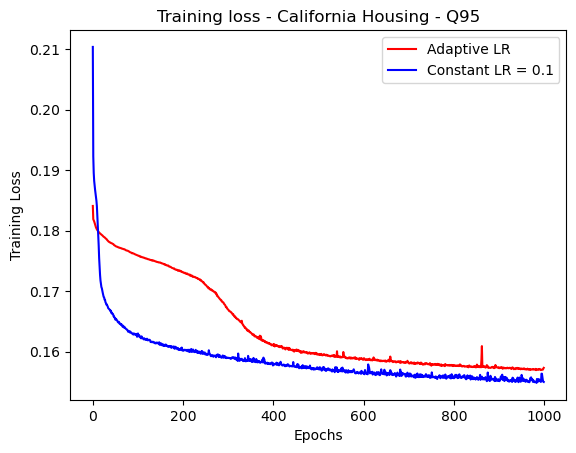

In [16]:

loss_adaptive = history_Q95.history['loss']
loss_constant = history_const_Q95.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - California Housing - Q95')
plt.savefig('Training_Loss-California_Housing-Q95.png')
plt.legend()



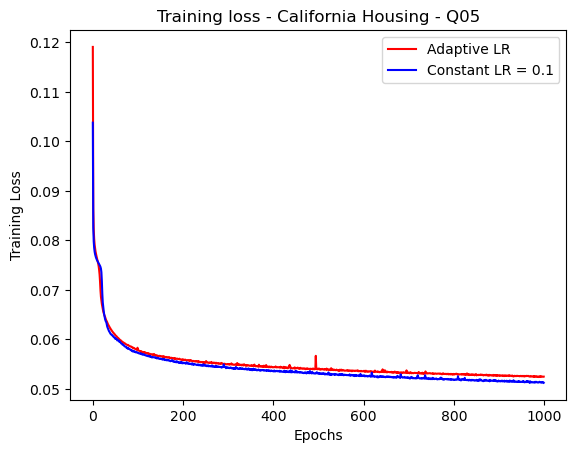

In [17]:
loss_adaptive = history_Q05.history['loss']
loss_constant = history_const_Q05.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - California Housing - Q05')
plt.savefig('Training_Loss-California_Housing-Q05.png')
plt.legend()



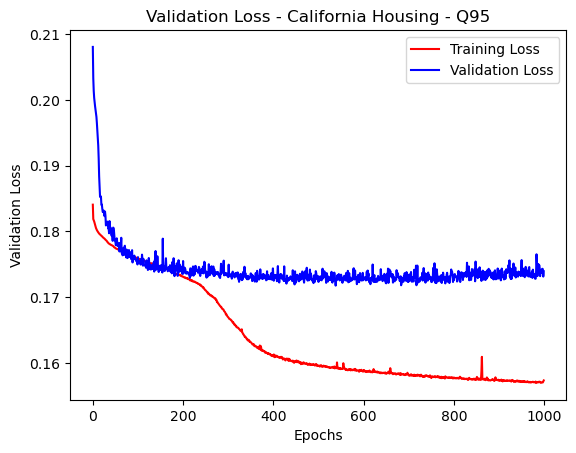

In [18]:
loss = history_Q95.history['loss']
val_loss = history_const_Q95.history['val_loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - California Housing - Q95')
plt.savefig('Validation_Loss-California_Housing-Q95-V.png')
plt.legend()



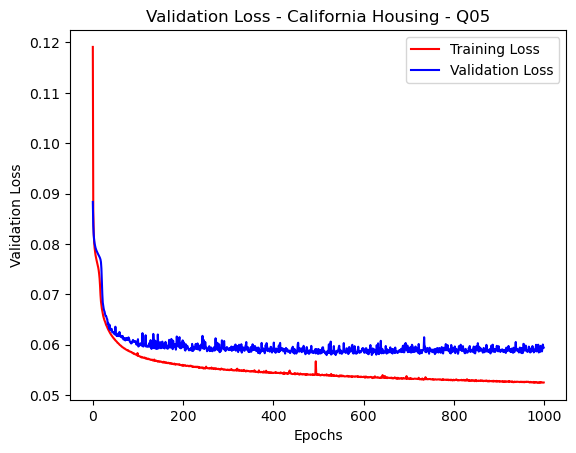

In [19]:
loss = history_Q05.history['loss']
val_loss = history_const_Q05.history['val_loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - California Housing - Q05')
plt.savefig('Validation_Loss-California_Housing-Q05-V.png')
plt.legend()